# Overview Analysis
In this notebook I investigate the overall trends in the data and identify areas worth exploring further

## Table of Contents
- [Data Preparation](#Data-Preparation)
- [Dataset Details](#Dataset-Details)
- [Overall Age Distribution](#Overall-Age-Distribution)
- [Normalised Age Distribution](#Normalised-Age-Distribution)
    - [Statistical Significance](#Statistical-Significance)
- [Medals per Age Band](#Medals-per-Age-Band)
- [Olympics Attended](#Olympics-Attended)
- [Summary](#Summary)
    - [Areas for Further Investigation](#Areas-for-Further-Investigation)

# Data-Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import DataCleaner
%matplotlib inline

In [2]:
# Read in data
athlete_events_df=pd.read_csv("data/athlete_events.csv")
noc_regions_df=pd.read_csv("data/noc_regions.csv",index_col="NOC")

In [3]:
# Clean data (See DataCleaner.py for details)
athlete_df=DataCleaner.clean_athlete_events(athlete_events_df)
noc_df=DataCleaner.clean_noc_regions(noc_regions_df)

In [4]:
# Add Field
athlete_df["Medalist"]=athlete_df["Medal"].isin(["gold","silver","bronze"]) # boolean for whether athlete won a medal
athlete_df["Birth_Year"]=athlete_df["Year"]-athlete_df["Age"]
athlete_df[["Age","Birth_Year"]]=athlete_df[["Age","Birth_Year"]].astype(int)

In [5]:
athlete_df.head()

,Athlete_ID,Name,Sex,Age,NOC,Year,Season,Sport,Event,Medal,Medalist,Birth_Year
1,2,a lamusi,M,23,chn,2012,summer,judo,extra-lightweight,NaN,False,1989
4,5,christine jacoba aaftink,F,21,ned,1988,winter,speed skating,500 metres,NaN,False,1967
5,5,christine jacoba aaftink,F,21,ned,1988,winter,speed skating,"1,000 metres",NaN,False,1967
6,5,christine jacoba aaftink,F,25,ned,1992,winter,speed skating,500 metres,NaN,False,1967
7,5,christine jacoba aaftink,F,25,ned,1992,winter,speed skating,"1,000 metres",NaN,False,1967


In [6]:
# Group data such that each athlete only has one entry
unique_athlete_df=DataCleaner.unique_athlete(athlete_df)
unique_athlete_df.head()

unique_athlete_df.to_csv("data/unique_athletes.csv")

C:\Users\domah\Documents\Code\Olympic-Analysis\DataCleaner.py:116: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  athlete_details=athlete_df.groupby(by="Athlete_ID")["Name","Sex","NOC","Season","Sport","Birth_Year"].first()
C:\Users\domah\Documents\Code\Olympic-Analysis\DataCleaner.py:117: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  unique_details=athlete_df.groupby(by="Athlete_ID")["Event","Year"].agg(['unique'])
c:\users\domah\appdata\local\programs\python\python37\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


# Dataset Details

In [7]:
print("`unique_athlete_df` contains {:,} athletes, {:,} of whom have won a medal.".format(unique_athlete_df.shape[0],unique_athlete_df["Medalist"].sum()))

print("`athlete_df` contains {:,} entries.".format(athlete_df.shape[0]))
summer_games=athlete_df[athlete_df["Season"]=="summer"]
winter_games=athlete_df[athlete_df["Season"]=="winter"]
print("\t{:,} athletes".format(len(athlete_df["Athlete_ID"].unique())))
print("\t{:,} medals".format(athlete_df["Athlete_ID"].notnull().sum()))
print("\t{} summer games ({}-{}).".format(len(summer_games["Year"].unique()),summer_games["Year"].min(),summer_games["Year"].max()))
print("\t{} winter games ({}-{}).".format(len(winter_games["Year"].unique()),winter_games["Year"].min(),winter_games["Year"].max()))
print("\t{} sports ({} summer, {} winter).".format(len(athlete_df["Sport"].unique()),len(summer_games["Sport"].unique()),len(winter_games["Sport"].unique())))
print("\t{} events ({} summer, {} winter).\n".format(len(athlete_df["Event"].unique()),len(summer_games["Event"].unique()),len(winter_games["Event"].unique())))

`unique_athlete_df` contains 91,562 athletes, 16,109 of whom have won a medal.
`athlete_df` contains 200,969 entries.
	91,562 athletes
	200,969 medals
	18 summer games (1948-2016).
	18 winter games (1948-2014).
	41 sports (27 summer, 14 winter).
	278 events (221 summer, 67 winter).



In [8]:
# labels for plots
medalist_label="Medalists (n={:,})".format(unique_athlete_df["Medalist"].sum())
competitor_label="All Competitors (n={:,})".format(unique_athlete_df.shape[0])

# Overall Age Distribution

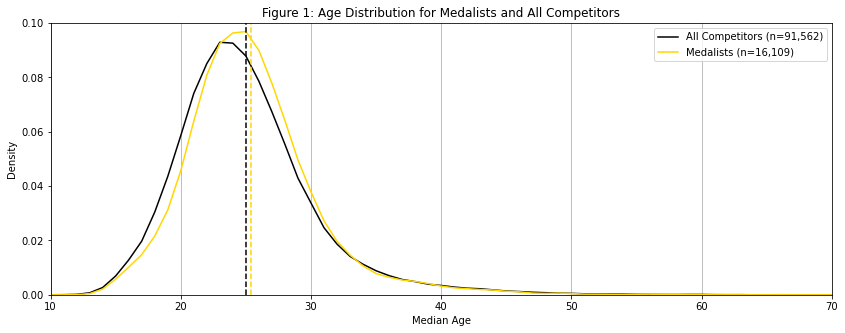

In [9]:
fig,axes=plt.subplots(figsize=(14,5),nrows=1,ncols=1)
# kde plot of age distribution for medal winners against non-winners
# suggests medal winners are slightly older
xlims=(10*(unique_athlete_df["Median_Age"].min()//10),10*np.ceil(unique_athlete_df["Median_Age"].max()/10))
ylims=(0,.1)
eval_points=[i for i in range(int(xlims[0]),int(xlims[1])+1)] # estimate distribution at each year

# Plot data
unique_athlete_df["Median_Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label=competitor_label,color="black",ax=axes)
unique_athlete_df[unique_athlete_df["Medalist"]]["Median_Age"].plot.kde(ind=eval_points,xlim=xlims,ylim=ylims,label=medalist_label,color="gold",ax=axes)

# Plot means
axes.axvline(x=unique_athlete_df["Median_Age"].mean(),color="black",ls="--")
axes.axvline(x=unique_athlete_df[unique_athlete_df["Medalist"]]["Median_Age"].mean(),color="gold",ls="--")

axes.set_title("Figure 1: Age Distribution for Medalists and All Competitors")
axes.set_xlabel("Median Age")
axes.xaxis.grid(True)
axes.legend()

This plot offers up nothing surprising. Most competitors are in their 20s and medalists are likely to be a bit older than their other competitors, likely due to greater experience.\
I shall now consider when an athlete was born in the olympic cycle.

# Normalised Age Distribution

In [10]:
# Determine how many years after an olympics an athlete was born
# This is complicated by the fact that the summer & winter games were in sync until 1994
summer_athletes=(unique_athlete_df["Season"]=="summer")
pre_change_winter_athletes=((unique_athlete_df["Season"]=="winter") & (unique_athlete_df["Birth_Year"]<1994))
post_change_winter_athletes=((unique_athlete_df["Season"]=="winter") & (unique_athlete_df["Birth_Year"]>=1994))

unique_athlete_df.loc[summer_athletes,"Cycle_Age"]=(unique_athlete_df.loc[summer_athletes,"Birth_Year"]%4)
unique_athlete_df.loc[pre_change_winter_athletes,"Cycle_Age"]=(unique_athlete_df.loc[pre_change_winter_athletes,"Birth_Year"]%4)
unique_athlete_df.loc[post_change_winter_athletes,"Cycle_Age"]=((unique_athlete_df.loc[post_change_winter_athletes,"Birth_Year"]-2)%4)

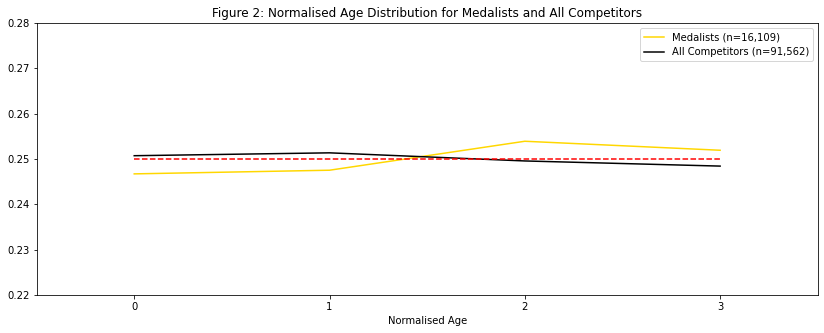

In [11]:
medalists=unique_athlete_df[unique_athlete_df["Medalist"]]["Cycle_Age"].value_counts(normalize=True).sort_index()
competitors=unique_athlete_df["Cycle_Age"].value_counts(normalize=True).sort_index()

fig,axes=plt.subplots(figsize=(14,5),nrows=1,ncols=1)
# kde plot of age distribution for medal winners against non-winners
# suggests medal winners are slightly older
xlims=(-.5,3.5)
x_tick_labels=range(0,4)
ylims=(.22,.28)
y_tick_labels=[x/100 for x in range(int(100*ylims[0]),int(100*ylims[1])+1,1)]

# Plot data for all athletes
medalists.plot(ax=axes,ylim=ylims,xlim=xlims,label=medalist_label,c="gold")
competitors.plot(ax=axes,ylim=ylims,xlim=xlims,label=competitor_label,c="black")

axes.set_title("Figure 2: Normalised Age Distribution for Medalists and All Competitors")
axes.axhline(y=.25,xmin=.125,xmax=.875,color="red",ls="--")
axes.set_xlabel("Normalised Age")
axes.set_xticks(x_tick_labels)
axes.set_yticks(y_tick_labels)
axes.legend()

Plot suggests that competitors in general are relatively uniformly distributed, although slightly more athletes are born in the first to years of the olympic cycle.\
Whereas, medalists do not appear to be uniformly distributed, with most medalists being more towards the end of the olympic cycle.\
The differences here are very small so I can going to test the statistical significance of these results.

## Statistical Significance

I use *Pearson's $\chi^2$ Test* to test whether the the normalised age distribution for Medalists and for competitors follow a uniform distribution.

In [12]:
from scipy.stats import chisquare

In [13]:
# Test whether the distribution for all *competitors* normalised age follows a uniform distribution
f_obs=unique_athlete_df["Cycle_Age"].value_counts().sort_index().values
f_exp=np.repeat(sum(f_obs)/4,4)
print("Observed occs: {}.\nExpected occs: {}".format(f_obs,f_exp))
_,p_value=chisquare(f_obs,f_exp)
print("p_value={:.8f}.\n{}Statistically Significant\n".format(p_value,"" if (p_value<=.1) else "*Not* "))

Observed occs: [22955 23013 22849 22745].
Expected occs: [22890.5 22890.5 22890.5 22890.5]
p_value=0.60683034.
*Not* Statistically Significant



In [14]:
# Test whether the distribution for all *medalists* normalised age follows a uniform distribution
f_obs=unique_athlete_df[unique_athlete_df["Medalist"]]["Cycle_Age"].value_counts().sort_index().values
f_exp=np.repeat(sum(f_obs)/4,4)
print("Observed occs: {}.\nExpected occs: {}".format(f_obs,f_exp))
_,p_value=chisquare(f_obs,f_exp)
print("p_value={:.8f}.\n{}Statistically Significant\n".format(p_value,"" if (p_value<=.1) else "*Not* "))

Observed occs: [3974 3987 4090 4058].
Expected occs: [4027.25 4027.25 4027.25 4027.25]
p_value=0.50891174.
*Not* Statistically Significant



Both tests show that the differences between the observed normalised age distribution and the expected distribution (a uniform distribution) are not statistically significant.\
Thus, on a macro level, I can say that what year someone was born does *not* play a significant part in whether they will become an olympian (or a medalist).

# Medals per Age Band

Text(0.5, 1.0, 'Figure 3: Mean Medals Won by each Normalised Age Group')

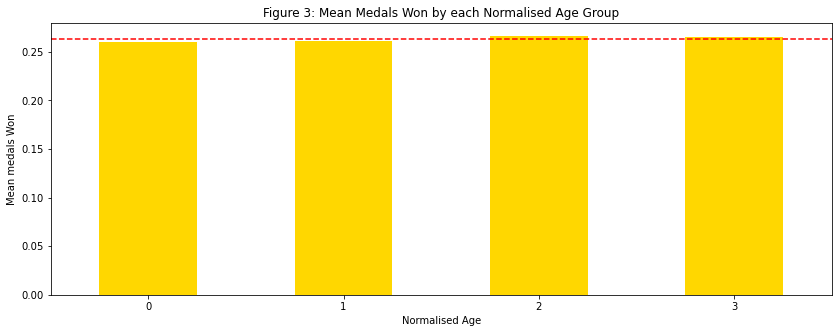

In [15]:
fig,axes=plt.subplots(figsize=(14,5),nrows=1,ncols=1)
normalised_age_group=unique_athlete_df.groupby("Cycle_Age")

medals_won=normalised_age_group["Num_Medals"].sum().sort_index()/normalised_age_group["Name"].count().sort_index()
medals_won.plot.bar(color="gold")

axes.axhline(y=medals_won.values.sum()/4,c="red",ls="--")
axes.set_xlabel("Normalised Age")
axes.set_xticks([0,1,2,3])
axes.set_xticklabels([0,1,2,3])
axes.xaxis.set_tick_params(rotation=0)
axes.set_ylabel("Mean medals Won")
axes.set_title("Figure 3: Mean Medals Won by each Normalised Age Group")

I supposed that perhaps multi-medal winners were not uniformly distributed. This plot shows the mean number of medals won by athletes falling into each of the normalised age categories. There is almost *no* discrepancy between each column, showing multi-medal winners are uniformly distributed too.

# Olympics Attended

Text(0.5, 1.0, 'Figure 4: Mean Olympics Attended by each Normalised Age Group')

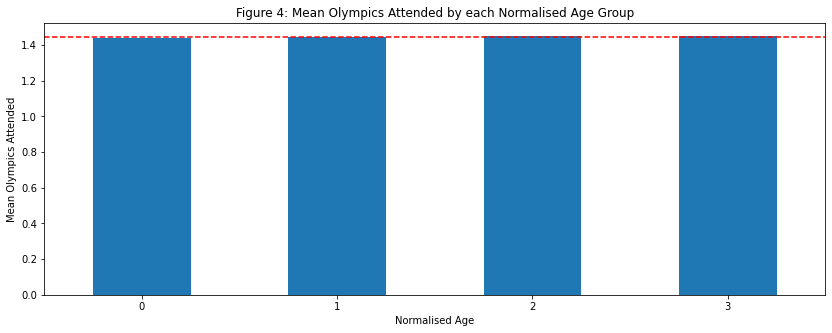

In [16]:
fig,axes=plt.subplots(figsize=(14,5),nrows=1,ncols=1)

unique_athlete_df["Num_Olympics"]=unique_athlete_df["Years"].apply(lambda x:len(x))
unique_athlete_df[["Years","Num_Olympics"]].head()
normalised_age_group=unique_athlete_df.groupby("Cycle_Age")

mean_attended=normalised_age_group["Num_Olympics"].sum().sort_index()/normalised_age_group["Name"].count().sort_index()
mean_attended.plot.bar(ax=axes)

axes.axhline(y=unique_athlete_df["Num_Olympics"].sum()/unique_athlete_df.shape[0],c="red",ls="--")
axes.set_xlabel("Normalised Age")
axes.set_xticks([0,1,2,3])
axes.set_xticklabels([0,1,2,3])
axes.xaxis.set_tick_params(rotation=0)
axes.set_ylabel("Mean Olympics Attended")
axes.set_title("Figure 4: Mean Olympics Attended by each Normalised Age Group")

I supposed that the longevity of an olympic athlete (ie how many olympics they attend) may depend on the year they were born.\ 

This plot shows the mean number of olympics attended by athletes falling into each of the normalised age categories. There is almost *no* discrepancy between each column, showing multi-medal winners are uniformly distributed too.\

I do expect that we shall see discrepancies in this measurement when considering individual sports as the optimal age range will vary from sport to sport, and so may not reflect in the overall population.

# Summary
There is no statistically significant evidence that being born in a particular year of an olympic cycle increases the probability that you will compete (or medal) in an Olympics.

## Areas for Further Investigation
With no unexpected results when looking at the data set as a whole, I am going to investigate different subsets. Namely split by:
- [Sex](Sex%20Analysis.ipynb)
<!--- [Winter or Summer Games](Season%20Analysis.ipynb)-->
- [Sport](Sport%20Analysis.ipynb)